In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy

2025-10-30 16:02:51.227376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 16:02:51.877220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Enable mixed precision training to optimize GPU memory usage
set_global_policy('mixed_float16')

In [3]:
# Define Paths
data_path = '../data/ISIC_2019_Training_Input'
csv_path = '../data/ISIC_2019_Training_GroundTruth.csv'

In [4]:
# Load metadata
df = pd.read_csv(csv_path)

In [5]:
# Add image paths to DataFrame for easy access
df['image_path'] = df['image'].apply(lambda x: os.path.join(data_path, x + '.jpg'))

In [6]:
# Convert one-hot encoded labels to categorical
class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
df['label'] = df[class_columns].idxmax(axis=1)

In [7]:
#  Split data into train (70%), validation (15%) and test (15%) sets
train_df, temp_df = train_test_split(df, test_size = 0.3, stratify = df['label'], random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df['label'], random_state = 42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 17731, Validation: 3800, Test: 3800


In [8]:
# Set up data augmentation for training and normalization for validation/test
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,    rotation_range = 20, # Random rotation up to 20 degrees
    width_shift_range = 0.2, # Random horizontal shift
    height_shift_range = 0.2, # Random vertical shift
    horizontal_flip = True, # Random horizontal flip
    zoom_range = 0.2, # Random zoom
    fill_mode = 'nearest' # Fill new pixels with nearest value
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input) # Only normalize for validation/test

# Configure data generators
target_size = (224, 224) # Resize images for EfficientNetB0
batch_size = 16 

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False # Keep test data order to evaluation   
)

print("Class indices:", train_generator.class_indices)

Found 17731 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Class indices: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [9]:
# Define class weights 
class_weights = {
    'AK': 3.652, 'BCC': 0.953, 'BKL': 1.207, 'DF': 13.248,
    'MEL': 0.700, 'NV': 0.246, 'SCC': 5.042, 'VASC': 12.515
}

In [10]:
class_indices = {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
class_weight_dict = {class_indices[cls]: weight for cls, weight in class_weights.items()}

In [11]:
# Load initial model
model_path = 'best_resnet50_model.keras'
model = load_model(model_path)

2025-10-30 16:02:53.744192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 16:02:53.779633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-30 16:02:53.782572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
# Unfreez last 20 layers
base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

Trainable layers: 20


In [13]:
# Recompile
model.compile(optimizer = Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1),
    ModelCheckpoint('best_finetuned_resnet50.keras', monitor = 'val_accuracy', save_best_only = True, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-7, verbose = 1)    
]

In [15]:
# Fine-tune
history_finetune = model.fit(
    train_generator,
    epochs = 20,
    validation_data = val_generator,
    class_weight = class_weight_dict,
    callbacks = callbacks,
    verbose = 1
)

/home/elnaz/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1761827584.553579   15789 service.cc:145] XLA service 0x740f88001e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761827584.553600   15789 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-30 16:03:04.807402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 16:03:05.998385: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2025-10-30 16:03:09.237830: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.125854, expected -nan
2025-10-30 16:03:09.237856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.232422, expected 0
2025-10-30 16:03:09.237860: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.131714, expected -nan
2025-

   1/1109 ━━━━━━━━━━━━━━━━━━━━ 10:13:25 33s/step - accuracy: 0.5000 - loss: 1.2174

I0000 00:00:1761827609.422736   15789 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 951/1109 ━━━━━━━━━━━━━━━━━━━━ 43s 273ms/step - accuracy: 0.5326 - loss: 1.4574 

2025-10-30 16:07:52.224408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.199951, expected -nan
2025-10-30 16:07:52.224431: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.125244, expected 0
2025-10-30 16:07:52.224439: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.204224, expected -nan
2025-10-30 16:07:52.224444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 0.199829, expected 0
2025-10-30 16:07:52.224450: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 0.182129, expected -nan
2025-10-30 16:07:52.224455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 0.118286, expected 0
2025-10-30 16:07:52.224460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 0.128296, expected -nan
2025-10-30 16:07:52.224466: E external/local_xla/xla/service/gpu/buffer_comparator.cc

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5317 - loss: 1.4420 

2025-10-30 16:09:33.717311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.142456, expected -nan
2025-10-30 16:09:33.717355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.202148, expected 0
2025-10-30 16:09:33.717361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.123108, expected -nan
2025-10-30 16:09:33.717365: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 0.14856, expected 0
2025-10-30 16:09:33.717369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 0.164917, expected -nan
2025-10-30 16:09:33.717372: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 0.128174, expected 0
2025-10-30 16:09:33.717376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 0.130737, expected -nan
2025-10-30 16:09:33.717379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:


Epoch 1: val_accuracy improved from None to 0.53184, saving model to best_finetuned_resnet50.keras
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 407s 337ms/step - accuracy: 0.5238 - loss: 1.3414 - val_accuracy: 0.5318 - val_loss: 1.1939 - learning_rate: 1.0000e-05
Epoch 2/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5237 - loss: 1.1360  
Epoch 2: val_accuracy improved from 0.53184 to 0.56632, saving model to best_finetuned_resnet50.keras
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 355s 320ms/step - accuracy: 0.5296 - loss: 1.1539 - val_accuracy: 0.5663 - val_loss: 1.1188 - learning_rate: 1.0000e-05
Epoch 3/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5357 - loss: 1.1077  
Epoch 3: val_accuracy improved from 0.56632 to 0.60158, saving model to best_finetuned_resnet50.keras
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 357s 322ms/step - accuracy: 0.5429 - loss: 1.1140 - val_accuracy: 0.6016 - val_loss: 1.0370 - learning_rate: 1.0000e-05
Epoch 4/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - a

In [16]:
# save history
with open('finetune_history.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

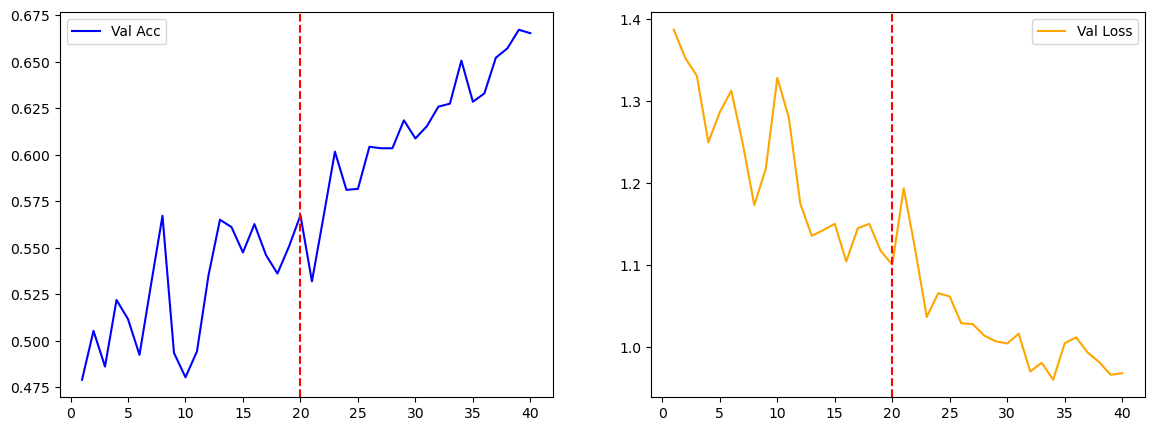

In [21]:
with open('training_history.pkl', 'rb') as f:
    h1 = pickle.load(f)
acc = h1['val_accuracy'] + history_finetune.history['val_accuracy']
loss = h1['val_loss'] + history_finetune.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label = 'Val Acc')
plt.axvline(len(h1['val_accuracy']), color = 'r', linestyle = '--')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'orange', label = 'Val Loss')
plt.axvline(len(h1['val_loss']), color = 'r', linestyle = '--')
plt.legend()
plt.savefig('finetuned_history.jpg')
plt.show()